### Anomaly detection and threat hunting on Windows logon data using anomalize

Reference original blog post by Russ Mcree:
<br>https://holisticinfosec.blogspot.com/2018/06/toolsmith-133-anomaly-detection-threat.html

## Global Parameters to Configure (TimeStamp, Host, User for Investigation)

In [23]:
FilteredComputer="WIN-DC01"
FilteredAccount = "SRVACCNT-01"
FilteredAccountList = c("ASHWIN","ERIC","JAMES","SRVACCNT-02")

In [2]:
#Suppress R Warnings
options(warn=-1)
# Load R Packages
pkgs <- c(pkgs <- c("tibbletime", "tidyverse","anomalize", "jsonlite", "curl", "httr", "lubridate","dplyr"))
sapply(pkgs, function(x) suppressPackageStartupMessages(require(x, character.only = T)))

tibbletime  tidyverse  anomalize   jsonlite       curl       httr  lubridate 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
     dplyr 
      TRUE

## Connection to Log Data Source (R Authentication)
Reference Blog Post on ADLS file operations in R: 
https://blogs.msdn.microsoft.com/microsoftrservertigerteam/2017/03/14/using-r-to-perform-filesystem-operations-on-azure-data-lake-store/

### Possible ways to retrieve credentials:
- Store and read from OS environment variable
- Store and read from static config file from filesystem which will be under auditing
- Store and read from Secret vault or other password stores using certificate based access
- Prompt user the password to store value for the first time

### Possible ways to download source data in scope
 - Uncomment below code only to download latest file once to read and download latest tsv files or 
 - Set up scheduled task to download relevant files and read from local file system

In [3]:
# Start ADL code to generate access token
h <- new_handle()

handle_setform(h,
               "grant_type"="client_credentials",
               "resource"="https://management.core.windows.net/",
               "client_id"="<CLIENT ID>",
               "client_secret"="<CLIENT SECRET>"
)
req <- curl_fetch_memory("https://login.microsoftonline.com/<TENANT ID>/oauth2/token", handle = h)
res <- fromJSON(rawToChar(req$content))
token <- res$access_token
r <- GET("https://<yourstorename>.azuredatalakestore.net/webhdfs/v1/local/Anomalizer/RawCSV/UserLogons-demo.csv?op=OPEN&read=true"
          , config = add_headers(Authorization = paste0("Bearer ",  token)))

writeBin(content(r), '/notebooks/RAWData/Demo/UserLogons-demo.tsv')

In [43]:
#Check the status of freshness of RawFiles . If it is not latest, download by uncommenting below code
file.info(list.files(path="/notebooks/RAWData/Demo/", full.names=TRUE)) %>% select(ctime)

,ctime
/notebooks/RAWData/Demo//HostLogons-demo.csv,2018-11-06 21:34:07
/notebooks/RAWData/Demo//UserLogons-demo.csv,2018-11-06 21:34:06


## Load the Data and check the schema

### Read CSV into R

In [44]:
# Read CSV into R
userlogondemo <- read.csv(file="/notebooks/RAWData/Demo/UserLogons-demo.csv", header=TRUE, sep=",")

### Printing the structure of the data

In [45]:
str(userlogondemo)

'data.frame':	2844 obs. of  6 variables:
 $ Date           : Factor w/ 107 levels "1/1/2018","1/10/2018",..: 20 20 20 20 20 20 20 20 20 20 ...
 $ EventId        : Factor w/ 1 level "Microsoft-Windows-Security-Auditing:4624": 1 1 1 1 1 1 1 1 1 1 ...
 $ AccountNtDomain: Factor w/ 1 level "LABDOMAIN.LOCAL": 1 1 1 1 1 1 1 1 1 1 ...
 $ AccountName    : Factor w/ 5 levels "ASHWIN","ERIC",..: 4 4 4 4 4 4 4 5 5 5 ...
 $ logontype      : int  10 11 2 4 7 10 4 3 3 5 ...
 $ TotalLogons    : int  28 2 15592 259 9 1 23 65 7 60 ...


### Printing Sample Rows from the dataset

In [46]:
head(userlogondemo)

Date,EventId,AccountNtDomain,AccountName,logontype,TotalLogons
1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,10,28
1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,11,2
1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,2,15592
1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,4,259
1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,7,9
1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,10,1


In [47]:
#Read Downloaded tsv from local dir
userlogonsummary <- read_delim("/notebooks/RAWData/Demo/UserLogons-demo.csv",delim =",") %>%
                    arrange(AccountName,AccountNtDomain,Date)

Parsed with column specification:
cols(
  Date = col_character(),
  EventId = col_character(),
  AccountNtDomain = col_character(),
  AccountName = col_character(),
  logontype = col_integer(),
  TotalLogons = col_integer()
)


In [48]:
# By User Logon View
byuser <- userslogonsummary %>%
          mutate(Date = as.Date(Date, "%m/%d/%Y")) %>% 
          group_by(Date, AccountName) %>%
          summarise(logoncount=sum(TotalLogons)) %>% 
          ungroup() %>%
          arrange(AccountName, Date)

head(byuser)

Date,AccountName,logoncount
2018-01-01,ASHWIN,563
2018-01-03,ASHWIN,1462
2018-01-04,ASHWIN,1416
2018-01-05,ASHWIN,2241
2018-01-06,ASHWIN,1830
2018-01-08,ASHWIN,278


In [49]:
#Read Downloaded csv from local dir
hostlogonsummary <- read_delim("/notebooks/RAWData/Demo/HostLogons-demo.csv",delim =",") %>%
                    arrange(ComputerName, AccountNtdomain,Date)

Parsed with column specification:
cols(
  Date = col_character(),
  EventId = col_character(),
  AccountNtdomain = col_character(),
  ComputerName = col_character(),
  logontype = col_integer(),
  TotalLogons = col_integer()
)


In [50]:
# By User Logon View
byhost <- hostlogonsummary %>%
          mutate(Date = as.Date(Date, "%m/%d/%Y")) %>% 
          group_by(Date, ComputerName) %>%
          summarise(logoncount=sum(TotalLogons)) %>% 
          ungroup() %>%
          arrange(ComputerName, Date)

head(byhost)

Date,ComputerName,logoncount
2018-01-03,WIN-DC01,176
2018-01-04,WIN-DC01,142
2018-01-05,WIN-DC01,85
2018-01-06,WIN-DC01,147
2018-01-07,WIN-DC01,142
2018-01-08,WIN-DC01,159


In [51]:
#Read Downloaded csv from local dir
userslogonsummary <- read_delim("/notebooks/RAWData/Demo/UserLogons-demo.csv",delim =",") %>%
  filter(AccountName %in% AccountName) %>%
  arrange(AccountName, AccountNtDomain, Date)

Parsed with column specification:
cols(
  Date = col_character(),
  EventId = col_character(),
  AccountNtDomain = col_character(),
  AccountName = col_character(),
  logontype = col_integer(),
  TotalLogons = col_integer()
)


### Anomalize : https://github.com/business-science/anomalize

anomalize enables a tidy workflow for detecting anomalies in data. The main functions are time_decompose(), anomalize(), and time_recompose(). When combined, it’s quite simple to decompose time series, detect anomalies, and create bands separating the “normal” data from the anomalous data

anomalize has three main functions:

> **time_decompose()**: Separates the time series into seasonal, trend, and remainder components

> **anomalize()**: Applies anomaly detection methods to the remainder component.

> **time_recompose()**: Calculates limits that separate the “normal” data from the anomalies!

### Plotting graph for specific host

Converting from tbl_df to tbl_time.
Auto-index message: index = Date
frequency = 7 days
median_span = 59 days


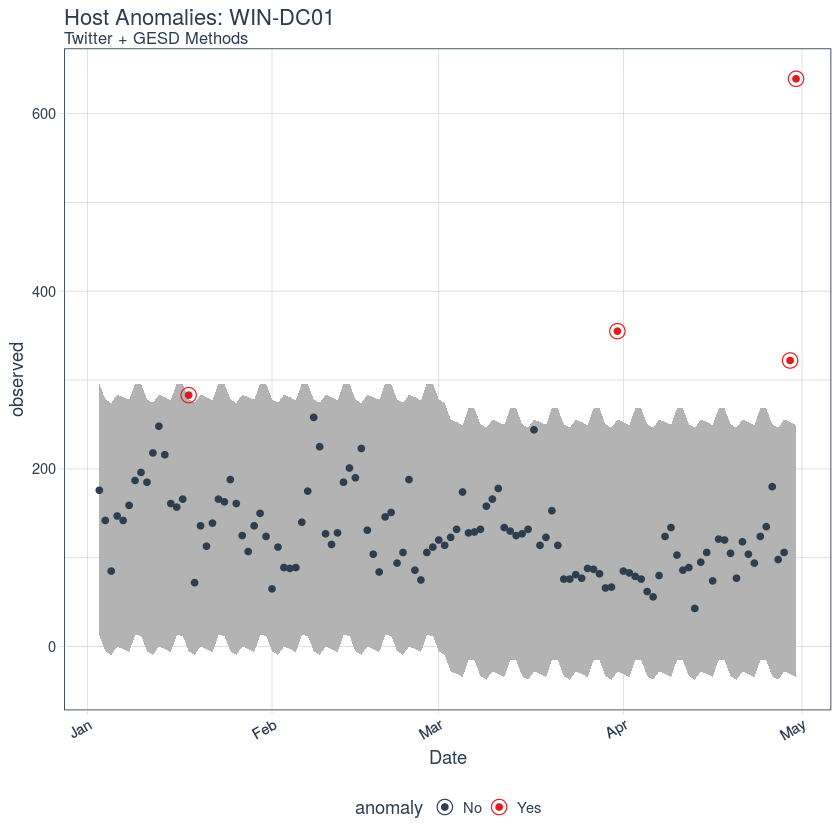

In [52]:
graphHost <- byhost %>%
  filter(ComputerName  == FilteredComputer) %>% 
  ungroup()%>%
  time_decompose(logoncount, method = "twitter", trend = "3 months") %>%
  anomalize(remainder, method = "gesd") %>%
  time_recompose() %>%
  # Anomaly Visualziation
  plot_anomalies(time_recomposed = TRUE) +
  labs(title = paste0("Host Anomalies: ",FilteredComputer), subtitle = "Twitter + GESD Methods")

plot(graphHost)

### Plotting graph for specific User

Converting from tbl_df to tbl_time.
Auto-index message: index = Date
frequency = 6 days
median_span = 53 days


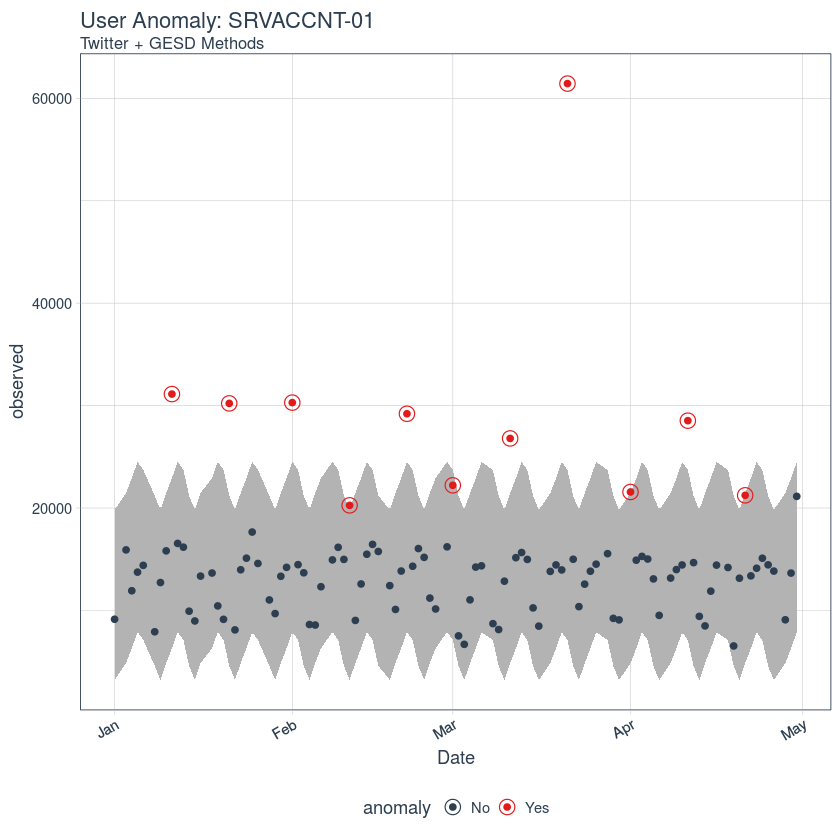

In [53]:
graphUser <- byuser %>%
  filter(AccountName == FilteredAccount) %>% 
  ungroup()%>%
  time_decompose(logoncount, method = "twitter", trend = "3 months") %>%
  anomalize(remainder, method = "gesd") %>%
  time_recompose() %>%
  # Anomaly Visualziation
  plot_anomalies(time_recomposed = TRUE) +
  labs(title = paste0("User Anomaly: ",FilteredAccount), subtitle = "Twitter + GESD Methods")

plot(graphUser)

### Plotting Anomalizer Graph for Multi Users

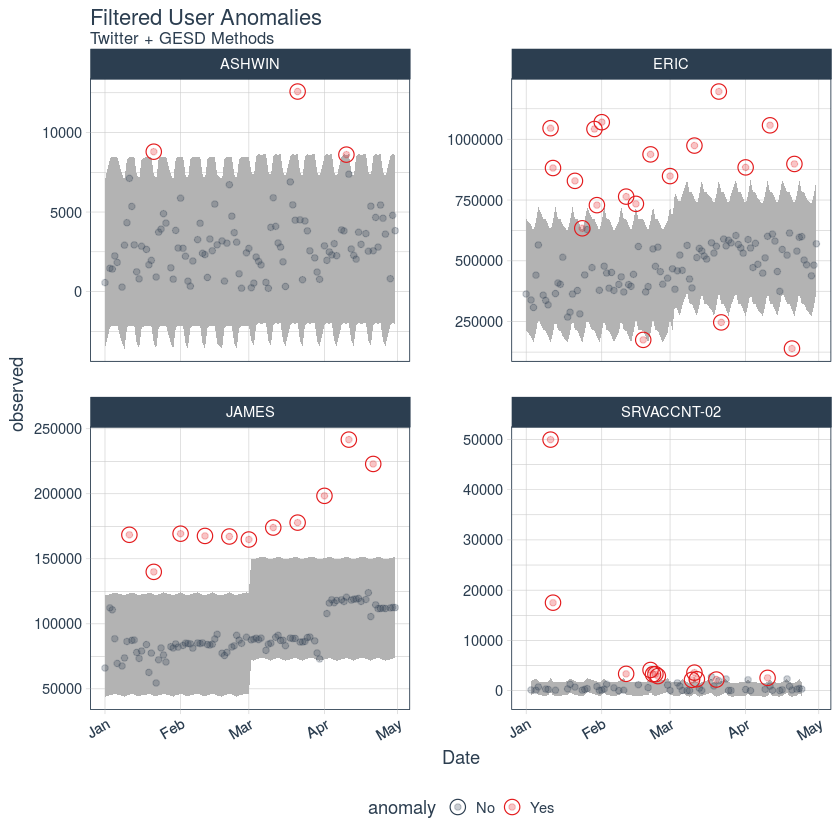

In [54]:
graphFilteredUsers <- byuser %>%
  filter(AccountName %in% FilteredAccountList) %>% 
  group_by(AccountName) %>% 
  as_tbl_time(Date)  %>% 
  time_decompose(logoncount, method = "twitter", trend = "3 months") %>%
  anomalize(remainder, method = "gesd") %>%
  time_recompose() %>%
  # Anomaly Visualziation
  plot_anomalies(time_recomposed = TRUE, ncol=2, alpha_dots = 0.25) +
  labs(title = "Filtered User Anomalies", subtitle = "Twitter + GESD Methods")

plot(graphFilteredUsers)

### Peeking into backend dataset which flagged Anomaly

In [55]:
 byhost %>%
  group_by(ComputerName) %>% 
  as_tbl_time(Date)  %>% 
  time_decompose(logoncount, method = "twitter", trend = "3 months") %>%
  anomalize(remainder, method = "gesd") %>%
  time_recompose()  %>% filter (anomaly=="Yes") %>% arrange(Date)

ComputerName,Date,observed,season,median_spans,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
WIN-DC01,2018-01-18,283,-5.3728342,142,146.3728,-141.753,141.753,Yes,-5.125793,278.3801
WIN-DC01,2018-03-31,355,-0.1313166,114,241.1313,-141.753,141.753,Yes,-27.884275,255.6216
WIN-DC01,2018-04-29,322,-2.9427030,114,210.9427,-141.753,141.753,Yes,-30.695662,252.8103
WIN-DC01,2018-04-30,639,-6.5444349,114,531.5444,-141.753,141.753,Yes,-34.297394,249.2085


### Observations:
- The library is robust to outlier and takes consideration of seasonality and trend in your logon dataset.
- The library works very well with non user account/service accounts which has consistent similar logon pattern, however ff there are users who has very random logon patterns it may flag large numer of logons as anamalous.

### Next Steps
- The library can be scoped for monitoring certain non users accounts inthe environments to be effectively flag anamalous activity.
- once flagged activity observed, load the logon activity for the suspicious users and investigate any other activity from the users to conclude if it is malicious or not.
- the library can be used with any other dataset with numerical data points eg. Powershell executions ibserved per account etc. 